In [1]:
import sys
sys.path.append("/csaf-system/components")

import acas.kernel as akern
import acas.trajectory as atraj
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
def f(x):
    return -x**3 + 3 * x**2 - 2 * x

def fp(x):
    return -3*x**2 + 6*x -2 

class RectangularArea:
    def __init__(self, upl, downr):
        self.upl, self.downr = upl, downr
        
    def __call__(self, pt):
        if isinstance(pt, np.ndarray):
            if len(pt.shape) == 2:
                assert pt.shape[1] == 2
                return np.array([self(p) for p in pt]).any()
        if not (self.upl[0] < pt[0] < self.downr[0]):
            return False
        if not (self.downr[1] < pt[1] < self.upl[1]):
            return False
        return True
    
    @property
    def center(self):
        return (np.mean((self.upl[0], self.downr[0])), np.mean((self.upl[1], self.downr[1])))
    
    @property
    def width(self):
        return np.abs(self.upl[0] - self.downr[0])
    
    @property
    def height(self):
        return np.abs(self.upl[1] - self.downr[1]) 

xs = [0, 0.1, 1, 1.5, 2.0]
pts = np.array([[x, f(x)] for x in xs])
vels = np.array([fp(x) for x in xs])

xsn = np.linspace(0, 2, 5)
ptsn = np.array([[x, f(x) + 0.2* np.random.rand()] for x in xsn])
velsn = np.array([fp(x)+ 0.2* np.random.rand() for x in xsn])

In [3]:
def plot_data(ax, pts, vels, dt = 0.1):
    """visualize point + tangent line"""
    ax.plot(*np.array(pts).T, 'ob')
    for idx, ((x, y), v) in enumerate(zip(pts, vels)):
        dx = [x - dt, x + dt]
        dy = [y - v * dt, y + v * dt]
        if idx == 0:
            ax.plot(dx, dy, 'b', label='Training Data')
        else:
            ax.plot(dx, dy, 'b')
            

def plot_rect(ax, rect):
    import matplotlib.patches as patches
    
    
    # Create a Rectangle patch
    rect = patches.Rectangle((rect.upl[0], rect.downr[1]), rect.width, rect.height, linewidth=1, 
                             edgecolor='r', facecolor='none', label='Keep Out Boundary')

    # Add the patch to the Axes
    ax.add_patch(rect)


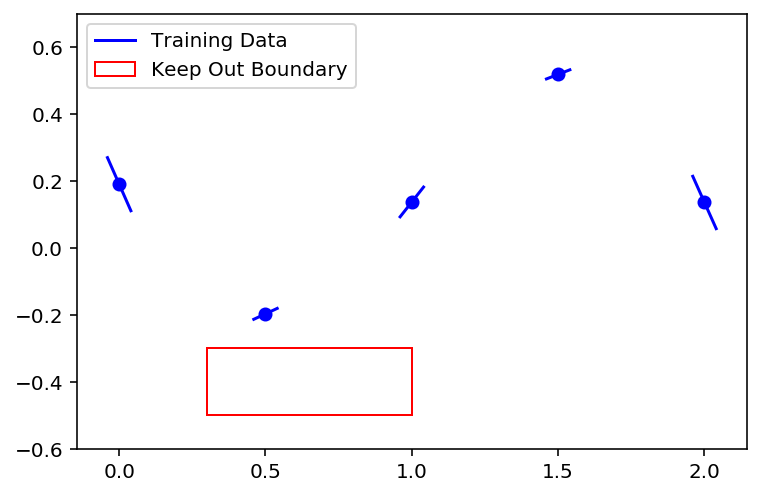

In [4]:
fig, ax = plt.subplots()
plot_data(ax, ptsn, velsn, dt=0.04)
plot_rect(ax, RectangularArea((0.3, -0.3), (1.0, -0.5)))
plt.ylim((-0.6, 0.7))
plt.legend()

In [5]:
pts = np.random.uniform(low=-1, high=1, size=(1000, 2))
pts[:, 0] += 1

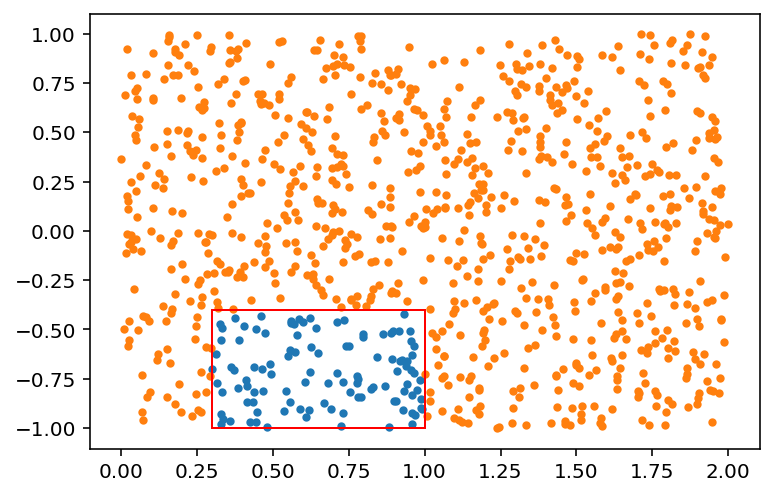

In [6]:
fig, ax = plt.subplots()
bound = RectangularArea((0.3, -0.4), (1.0, -1.0))
plot_rect(ax, bound)
y = np.array([bound(pt) for pt in pts])
plt.scatter(*pts[y==True].T, s=10)
plt.scatter(*pts[y==False].T, s=10)


In [7]:
te = atraj.CubicSplineTrajectoryEstimator(10.0, 5.0, 5.0)
te.fit(ptsn[:, 0], np.vstack([ptsn[:, 1], velsn]).T)

In [8]:
nt = np.linspace(0, 3.0, 100)
cov = akern.build_kernel_matrix(te.covariance, nt, nt)
vn = np.array([te.mu(ti) for ti in nt])

In [9]:
trajs = []
for i in range(0, 500):
    ys = np.random.multivariate_normal(vn, cov)
    trajs.append(np.vstack((nt, ys)).T)
    #plt_vals.append([nt, [ys[idx] for idx in range(0, len(ys), 2)]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
failed = [bound(t) for t in trajs]


In [11]:
def compute_proba(nt, vn, cov, bound, samples=100):
    failures = 0
    for i in range(0, samples):
        ys = np.random.multivariate_normal(vn, cov)
        if bound(np.vstack((nt, ys)).T):
            failures += 1
    return 1 - failures / samples

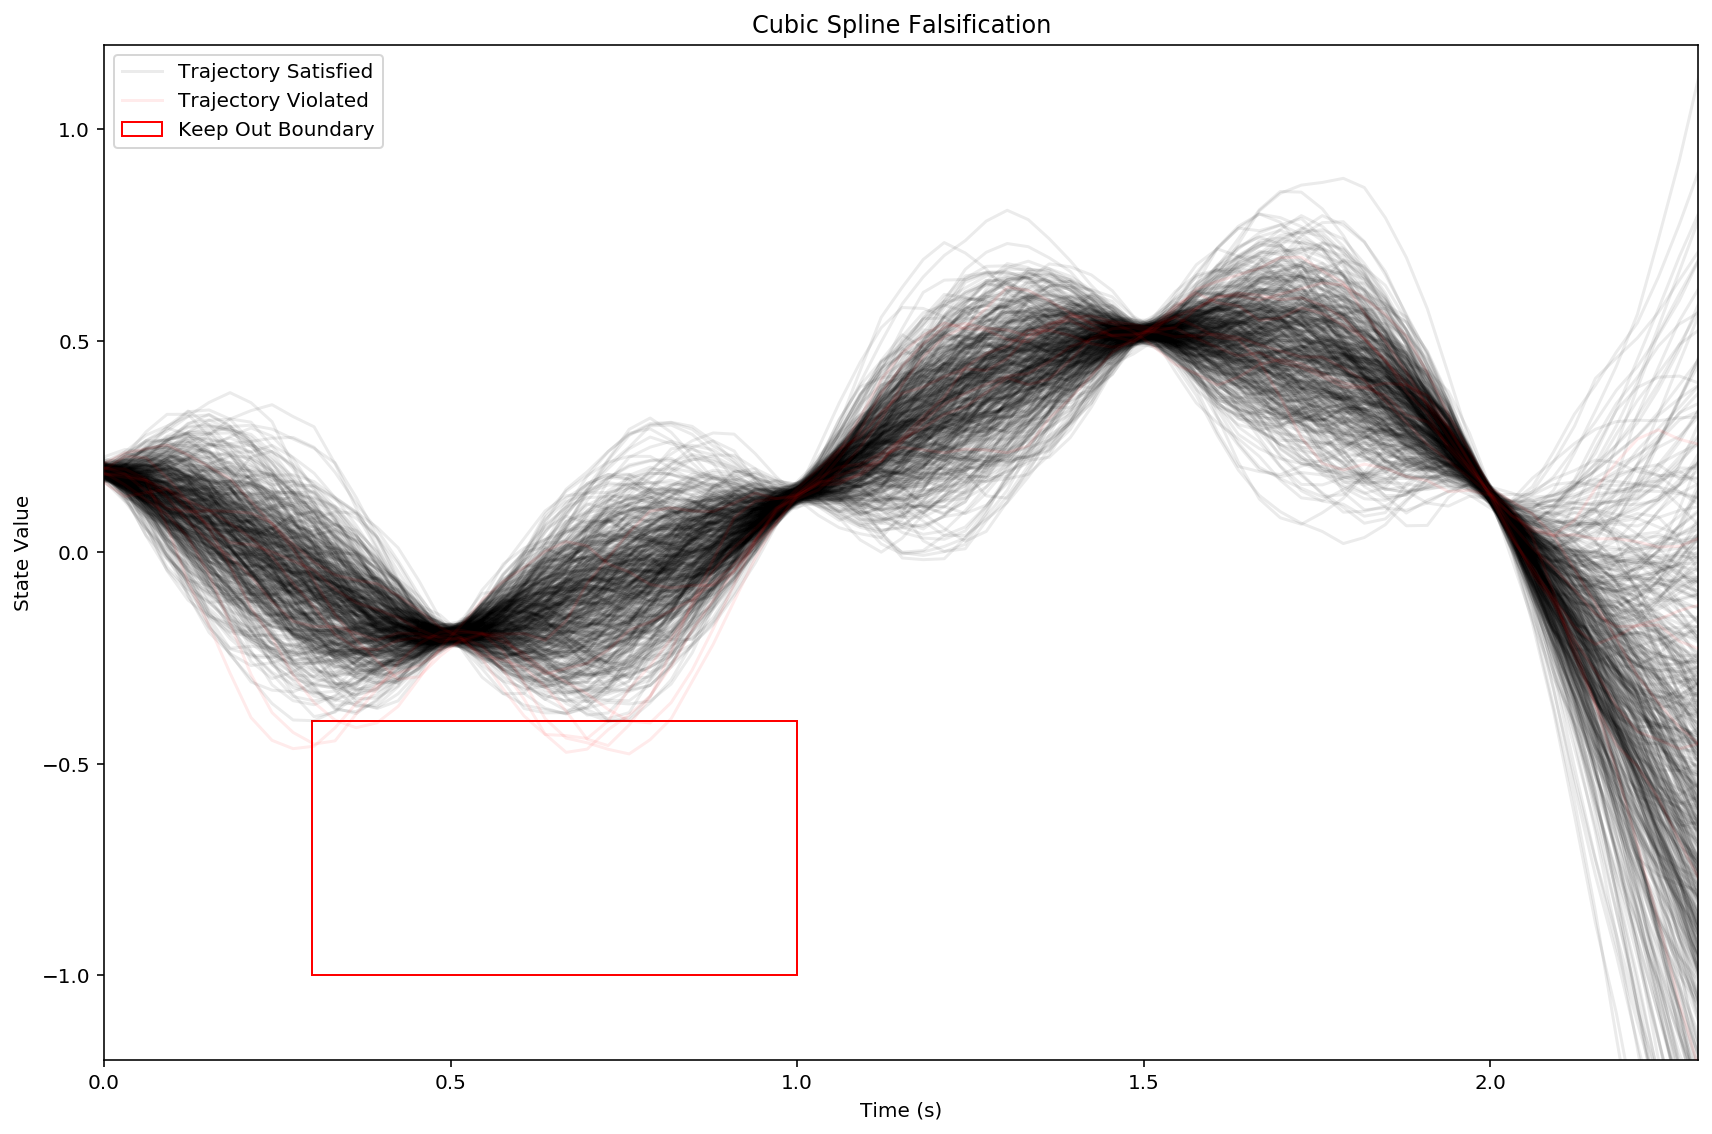

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
vf, sf = True, True
for idx, (t, f) in enumerate(zip(trajs, failed)):
    if f:
        plt.plot(*t.T, 'r', alpha=0.08, zorder=1000, label="Trajectory Violated" if vf else None)
        vf = False
    else:
        plt.plot(*t.T, 'k', alpha=0.08, label="Trajectory Satisfied" if sf else None)
        sf = False
    
plot_rect(ax, bound)
plt.xlim([0, 2.3])
plt.ylim([-1.2, 1.2])

ax.set_xlabel("Time (s)")
ax.set_ylabel("State Value")
ax.set_title("Cubic Spline Falsification")
plt.tight_layout()

plt.legend()

In [13]:
exps = []
for _ in range(10):
    samples = np.logspace(1, 3, 30)
    probs = []
    for s in samples:
        probs.append(compute_proba(nt, vn, cov, bound, samples=int(s)))
    exps.append((samples, probs))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  after removing the cwd from sys.path.


In [14]:
probs = np.array([p for _, p in exps])
samples = exps[0][0]
probmean, probstd = np.mean(probs, axis=0), np.std(probs, axis=0)

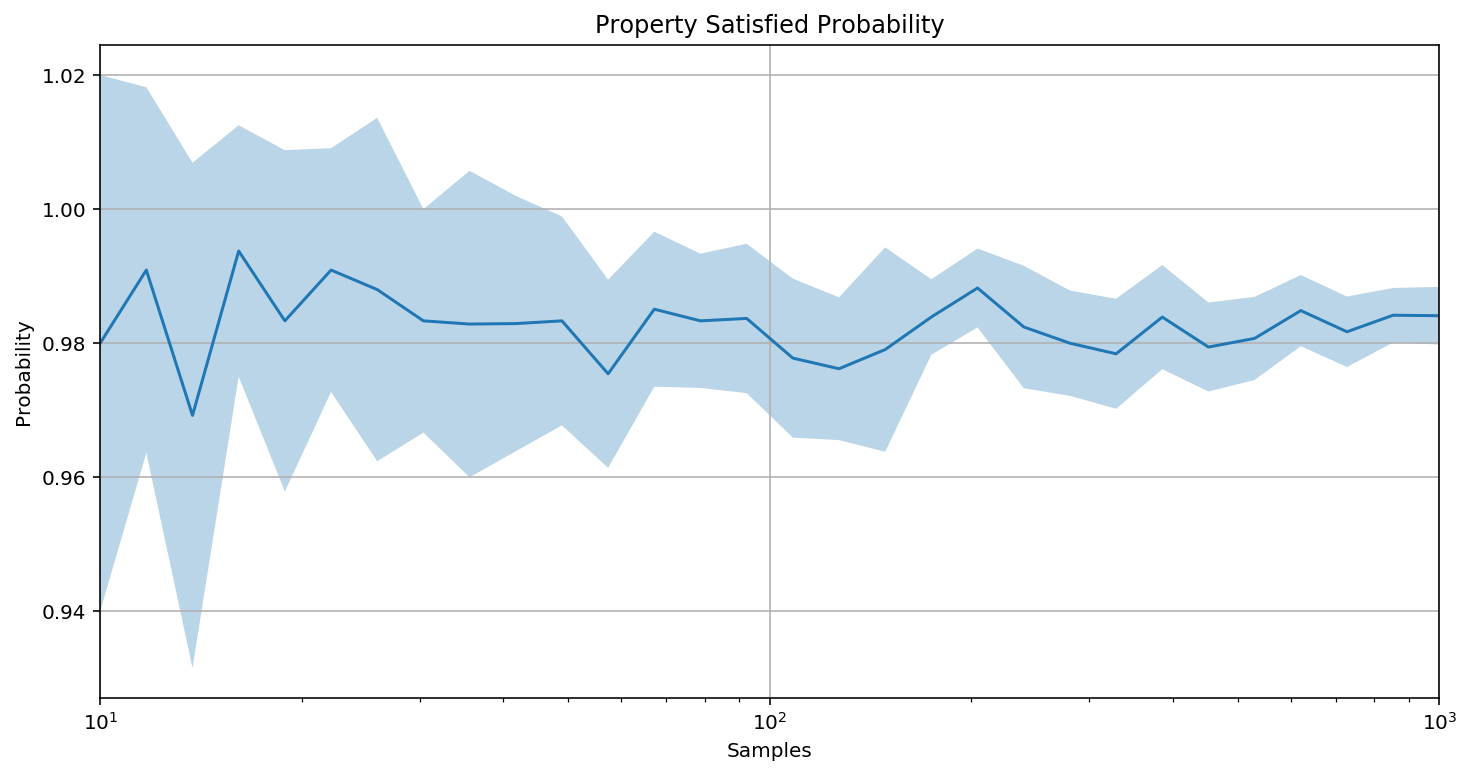

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(samples, probmean)
plt.fill_between(samples, probmean+probstd, probmean-probstd, alpha=0.3)
plt.xlim(min(samples), max(samples))
plt.title("Property Satisfied Probability")
plt.xscale("log")
plt.xlabel("Samples")
plt.ylabel("Probability")
plt.grid()